# resampler: example usage

[**[Open in Colab]**](https://colab.research.google.com/github/hhoppe/resampler/blob/main/example_usage.ipynb)
&nbsp;
[**[Kaggle]**](https://www.kaggle.com/notebooks/welcome?src=https://github.com/hhoppe/resampler/blob/main/example_usage.ipynb)
&nbsp;
[**[MyBinder]**](https://mybinder.org/v2/gh/hhoppe/resampler/main?filepath=example_usage.ipynb)
&nbsp;
[**[DeepNote]**](https://deepnote.com/launch?url=https%3A%2F%2Fgithub.com%2Fhhoppe%2Fresampler%2Fblob%2Fmain%2Fexample_usage.ipynb)
&nbsp;
[**[GitHub source]**](https://github.com/hhoppe/resampler)
&nbsp;
[**[API docs]**](https://hhoppe.github.io/resampler/)
&nbsp;
[**[PyPI package]**](https://pypi.org/project/resampler/)

In [1]:
!pip install -q mediapy resampler

In [2]:
"""Simple examples of `resampler` usage."""

import collections

import mediapy as media
import numpy as np
import matplotlib.pyplot as plt

import resampler

### Upsample an image (magnification)

4x6,128x192

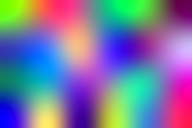

In [3]:
array = np.random.default_rng(1).random((4, 6, 3))  # 4x6 RGB image.
upsampled = resampler.resize(array, (128, 192))  # To 128x192 resolution.
media.show_images({'4x6': array, '128x192': upsampled}, height=128)

### Downsample an image (minification)

128x128,32x32

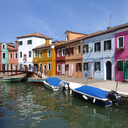
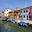

In [4]:
image = media.read_image('https://github.com/hhoppe/data/raw/main/image.png')
downsampled = resampler.resize(image, (32, 32))
media.show_images({'128x128': image, '32x32': downsampled}, height=128)

96x192,24x48

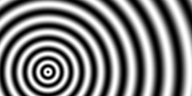

In [27]:
yx = (np.moveaxis(np.indices((96, 192)), 0, -1) + (0.5, 0.5)) / 96
radius = np.linalg.norm(yx - (0.75, 0.5), axis=-1)
array = np.cos((radius + 0.1) ** 0.5 * 70.0) * 0.5 + 0.5
downsampled = resampler.resize(array, (24, 48))
media.show_images({'96x192': array, '24x48': downsampled}, height=96, vmin=0, vmax=1)

### Upsample a 1D array

In [5]:
a = [3.0, 5.0, 8.0, 7.0]  # 4 source samples in 1D.
new_dual = resampler.resize(a, (32,))  # (default gridtype='dual') 8x resolution.
new_primal = resampler.resize(a, (25,), gridtype='primal')  # 8x resolution.

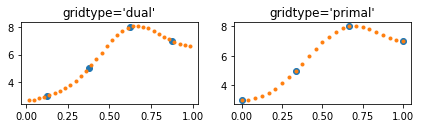

In [6]:
_, axs = plt.subplots(1, 2, figsize=(7, 1.5))
axs[0].set_title("gridtype='dual'")
axs[0].plot((np.arange(len(a)) + 0.5) / len(a), a, 'o')
axs[0].plot((np.arange(len(new_dual)) + 0.5) / len(new_dual), new_dual, '.')
axs[1].set_title("gridtype='primal'")
axs[1].plot(np.arange(len(a)) / (len(a) - 1), a, 'o')
axs[1].plot(np.arange(len(new_primal)) / (len(new_primal) - 1), new_primal, '.')
plt.show()

### Upsample a video

In [7]:
batch_size = 4
batch_of_images = media.moving_circle((16, 16), batch_size)
upsampled = resampler.resize(batch_of_images, (batch_size, 64, 64))
media.show_videos({'original': batch_of_images, 'upsampled': upsampled}, fps=1)

"original <source src=""data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAA+FtZGF0AAACfgYF//963EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEgbG9va2FoZWFkX3RocmVhZHM9MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxhY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHlyYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjPWNxcCBtYnRyZWU9MCBxcD0yMCBpcF9yYXRpbz0xLjQwIHBiX3JhdGlvPTEuMzAgYXE9MACAAAAAdGWIhAD/feG/QafKMUlOBmCnwSeV8TaWPllX9mYwLRT6sXFMpANEdUpywEteJ3yNcQvhy5hgqmI1zSdQQWwEZ05L7k+zDGVC9O7CeIGB1BxFd3eoV94V/4TcRfUScizasHSb7tUSTAWgXmJgoxCIu3eRoqiBAAAANkGaIWx/BNfL8AqP/viqgX8CDMh7v3rit/sYFOisKt7ypC5uhVP3JftcSTQyeC4VugYkzIOnvgAAAG5liIIAP33hvgMntt+xSU4GYKfBJ5XxNpY+WVf2ZjAtFPqxhq2wq9XJ2wihwBBNbMf9JozJK+J9nA4Lh4+Yu2AQJmBv5RXFFQlIrEJ1BxFkN4faUVeK+Nol1m+0pT4rcUKMDuMUGRAGOK12AyNf8QAAAC9BmiFsf2SOfAsd//8MTSlpDQJSdoJkJo2Y5bLSY+QwOfunGx7eJ2BlC62+p2BzMAAAA0Rtb292AAAAbG12aGQAAAAAAAAAAAAAAAAAAAPoAAAPoAABAAABAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAACbnRyYWsAAABcdGtoZAAAAAMAAAAAAAAAAAAAAAEAAAAAAAAPoAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAEAAAAAAEAAAABAAAAAAACRlZHRzAAAAHGVsc3QAAAAAAAAAAQAAD6AAAIAAAAEAAAAAAeZtZGlhAAAAIG1kaGQAAAAAAAAAAAAAAAAAAEAAAAEAAFXEAAAAAAAtaGRscgAAAAAAAAAAdmlkZQAAAAAAAAAAAAAAAFZpZGVvSGFuZGxlcgAAAAGRbWluZgAAABR2bWhkAAAAAQAAAAAAAAAAAAAAJGRpbmYAAAAcZHJlZgAAAAAAAAABAAAADHVybCAAAAABAAABUXN0YmwAAACtc3RzZAAAAAAAAAABAAAAnWF2YzEAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAEAAQAEgAAABIAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAY//8AAAAzYXZjQwFkAAr/4QAWZ2QACqzZXoQAAAMABAAAAwAIPEiWWAEABmjr4bLIsP34+AAAAAAUYnRydAAAAAAAAAeyAAAHsgAAABhzdHRzAAAAAAAAAAEAAAAEAABAAAAAABhzdHNzAAAAAAAAAAIAAAABAAAAAwAAABhjdHRzAAAAAAAAAAEAAAAEAACAAAAAABxzdHNjAAAAAAAAAAEAAAABAAAABAAAAAEAAAAkc3RzegAAAAAAAAAAAAAABAAAAvoAAAA6AAAAcgAAADMAAAAUc3RjbwAAAAAAAAABAAAAMAAAAGJ1ZHRhAAAAWm1ldGEAAAAAAAAAIWhkbHIAAAAAAAAAAG1kaXJhcHBsAAAAAAAAAAAAAAAALWlsc3QAAAAlqXRvbwAAAB1kYXRhAAAAAQAAAABMYXZmNTguNzYuMTAw"" type=""video/mp4""/> This browser does not support the video tag.","upsampled <source src=""data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAABtFtZGF0AAACfgYF//963EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTIgbG9va2FoZWFkX3RocmVhZHM9MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxhY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHlyYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjPWNxcCBtYnRyZWU9MCBxcD0yMCBpcF9yYXRpbz0xLjQwIHBiX3JhdGlvPTEuMzAgYXE9MACAAAACAmWIhAD/47h/yqaJ5X558BqAcg7Hu4or2GArj/yT0HWEu138X7HY8qU6tsPgGO85iLYkGVkufR1LCfAcJldyHgoORSXUCz8S1J4zFwYrPAdKcQ6RTJSpCRh1MC/XPL9FdQxkvepWmpq9WSINbdyCJnuHaMf+MkzZK0fJlStHEvJIUGkbcjhere3e3xwT6qHGAbQlxLlk5PiSmw4w6QvVWADS+8XZ1cQshXOkQb6F1gP9DDrR4qHJI7pnI6HYdaZ2COSR3I2RJmnqPJoJSNjDaZb+VJ+aleTkKjB+qkqTA6QczlU2L45SqT6njXZ1JF88rE6wbL1uxfIz1G7BazuFXA9LCO/MPSebMtva7wAaPqQuJxzpf9XuYf0fgoRJsJexsJJPdzGt8odXFO7Y7uYA/utsgV812RzVUbkJ4

### Advanced resizing options

Map an image to a wider grid using custom `scale` and `translate` vectors,
with horizontal `'reflect'` and vertical `'natural'` boundary rules,
providing a constant value for the exterior,
using different filters (Lanczos and O-MOMS) in the two dimensions,
disabling gamma correction, performing computations in double-precision,
and returning an output array in single-precision:

image,new

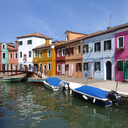
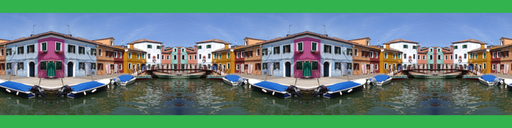

In [8]:
new = resampler.resize(
    image,
    (128, 512),
    boundary=('natural', 'reflect'),
    cval=(0.2, 0.7, 0.3),
    filter=('lanczos3', 'omoms5'),
    gamma='identity',
    scale=(0.8, 0.25),
    translate=(0.1, 0.35),
    precision='float64',
    dtype='float32',
)
media.show_images({'image': image, 'new': new})

### Translation

In [9]:
videos = collections.defaultdict(list)
for filter in ['impulse', 'triangle', 'lanczos3']:
  for angle in np.linspace(0.0, 2 * np.pi, 20, endpoint=False):
    translate = np.array([np.cos(angle), np.sin(angle)]) * (0.6 / image.shape[0])
    videos[f"filter='{filter}'"].append(
        resampler.resize(image, image.shape[:2], filter=filter, translate=translate)
    )

media.show_videos(videos, fps=20)

### Translation with upscaling

In [10]:
videos = collections.defaultdict(list)
for filter in ['impulse', 'triangle', 'lanczos3']:
  for angle in np.linspace(0.0, 2 * np.pi, 20, endpoint=False):
    translate = np.array([np.cos(angle), np.sin(angle)]) * (0.6 / image.shape[0]) + [-0.4, 0.0]
    scale = 2.0
    videos[f"filter='{filter}'"].append(
        resampler.resize(image, image.shape[:2], filter=filter, translate=translate, scale=scale)
    )

media.show_videos(videos, fps=20)

### Translation with downscaling

In [11]:
videos = collections.defaultdict(list)
for filter in ['impulse', 'triangle', 'trapezoid', 'lanczos3']:
  for angle in np.linspace(0.0, 2 * np.pi, 20, endpoint=False):
    translate = np.array([np.cos(angle), np.sin(angle)]) * (0.6 / image.shape[0]) + [0.0, 0.0]
    new_shape = np.array(image.shape[:2]) // 2
    videos[f"filter='{filter}'"].append(
        resampler.resize(image, new_shape, filter=filter, translate=translate)
    )

media.show_videos(videos, fps=20, height=image.shape[0])

### Rotation

### General resampling

Warp an image by transforming it using
[polar coordinates](https://en.wikipedia.org/wiki/Polar_coordinate_system):

image,resampled

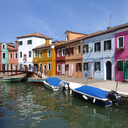
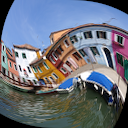

In [12]:
shape = image.shape[:2]
yx = ((np.indices(shape).T + 0.5) / shape - 0.5).T  # [-0.5, 0.5]^2
radius, angle = np.linalg.norm(yx, axis=0), np.arctan2(*yx)
angle += (0.8 - radius).clip(0, 1) * 2.0 - 0.6
coords = np.dstack((np.sin(angle) * radius, np.cos(angle) * radius)) + 0.5
resampled = resampler.resample(image, coords, boundary='constant')
media.show_images({'image': image, 'resampled': resampled})